In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
import torch
from calflops import calculate_flops
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.utils import calc_model_flops, hash_dict
import sqlite3
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import random
from sophius.train import train_on_gpu_ex
from sophius.estimate import LSTMRegressor

normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()
estimator = torch.load('../data/models/estimator_v1.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

def read_model_db(model_id):    
    with sqlite3.connect('../data/models.db') as conn:
        hash_str = conn.execute(f'SELECT hash FROM models WHERE id==?', (model_id, )).fetchone()[0]
    return encoder.hash2model(hash_str, (3, 32, 32), 10)

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


In [3]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=16, lin_num=3)
res = pd.DataFrame(columns=['est_val_acc', 'conv_len'])

for i in tqdm(range(10000)):
    model_tmpl = model_gen.generate_model_tmpl()    
    est_val_acc = estimate_acc(model_tmpl)
    if est_val_acc < 0.7:
        # print('Skip %.3f' % est_val_acc)
        continue
    res.loc[i, 'est_val_acc'] = est_val_acc
    res.loc[i, 'conv_len'] = model_tmpl.get_conv_len()
    # print('Pass %.3f' % est_val_acc)

100%|██████████| 10000/10000 [00:25<00:00, 393.99it/s]


In [ ]:
from matplotlib import pyplot as plt

plt.figure.s

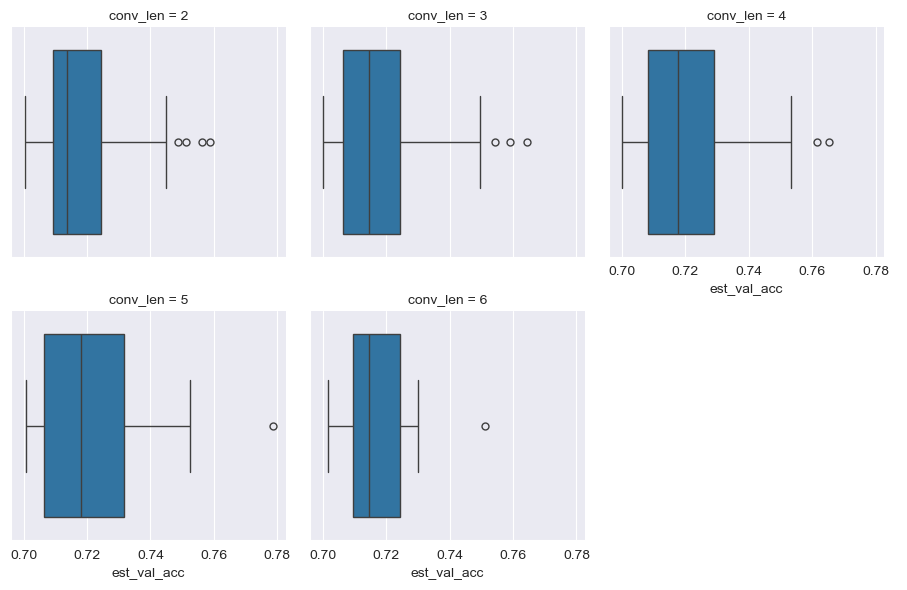

In [8]:
sns.catplot(res.query('1 < conv_len < 7'), x='est_val_acc', col='conv_len', col_wrap=3, height=3, kind='box');